In [209]:
#!/usr/bin/python
import nltk
import numpy as np
import re
import tensorflow as tf
from nltk.corpus import stopwords
from nltk.tokenize import WordPunctTokenizer
from random import randint
from sklearn.model_selection import train_test_split
import random
import pandas as pd
import itertools
from nltk.stem.wordnet import WordNetLemmatizer 
from collections import namedtuple
from collections import defaultdict
from tqdm import tqdm
from sklearn.metrics import precision_score
from sklearn.metrics import f1_score
from sklearn.metrics import recall_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
import math

Importing Glove and  40000 words list 

In [2]:
wordsList = np.load('wordsList.npy')
print('Loaded the word list!')
wordsList = wordsList.tolist() #Originally loaded as numpy array
wordsList = [word.decode('UTF-8') for word in wordsList] #Encode words as UTF-8
wordVectors = np.load('wordVectors.npy')
print ('Loaded the word vectors!')
print(len(wordsList))
print(wordVectors.shape)
print(wordsList[5066])
print(wordVectors[5066][:])

Loaded the word list!
Loaded the word vectors!
400000
(400000, 50)
closure
[ 0.50653   0.12284  -0.11653  -0.21052  -1.0672   -0.17536   0.16253
  0.76781   0.25517  -0.15995   0.025424 -0.65425  -0.44638  -0.19395
  0.45319   1.0955    0.050096 -0.36712   0.1729    0.28393   0.85448
 -0.54932  -1.1816    0.066158 -0.58561  -0.84893   0.1947    0.37832
  0.94141   0.62982   2.3869   -0.41035  -0.11599   0.049907 -0.41563
 -0.056999  1.5044   -0.93772  -0.16045   0.80019  -0.44448  -0.50036
  0.065875  0.27778  -0.27505  -0.012317 -0.37458   0.49171  -0.35498
  0.035347]


Importing the Dataset 

In [27]:
#--------------------Extracting Emotion && sentences from corpus
def extract(dataset):
    f = open(dataset, 'r+', encoding='utf-8')
    linea = f.readline()
    emotion = []
    sentences = []
    neutro = re.compile('^ne')
    while linea != "":    
        #Ignoramos Neutro emotions
        if not re.match(neutro, linea):
            #print("** ",linea)
            linea = linea.split("**@**")
            #print(len(linea))
            #Obtaining the emocion
            emotion.append(linea[2])
            sentences.append(linea[1])
        linea = f.readline()
    f.close()
    return sentences,emotion

dataset = "TwitterDataset/Train/train_valid_test.txt"
sentences,emotions = extract(dataset)
print(emotions[0]," ",sentences[0])
print("Labels: ",len(emotions), "Sentences: ",len(sentences))

anger   How the fu*k! Who the heck! moved my fridge!... should I knock the landlord door. #angry #mad ##
Labels:  7102 Sentences:  7102


In [28]:
import csv
with open('TwitterDataset/Train/train__test_valid.csv', mode='w', encoding='utf-8') as emo_file:
    emo_writer = csv.writer(emo_file, delimiter=',', quotechar='"', quoting=csv.QUOTE_MINIMAL)
    emo_writer.writerow(['Emotions', 'Sentence'])
    for i in range(0,len(emotions)):
        emo_writer.writerow([emotions[i],sentences[i]])

In [29]:
train = pd.read_csv("TwitterDataset/Train/train__test_valid.csv", delimiter=",")
train.head()

,Emotions,Sentence
0,anger,How the fu*k! Who the heck! moved my fridge!.....
1,anger,So my Indian Uber driver just called someone t...
2,anger,@DPD_UK I asked for my parcel to be delivered ...
3,anger,so ef whichever butt wipe pulled the fire alar...
4,anger,Don't join @BTCare they put the phone down on ...


Cuánto hay de cada emoción

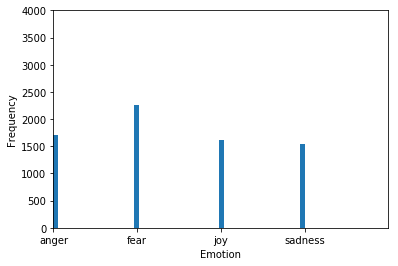

In [30]:
import matplotlib.pyplot as plt
import collections
%matplotlib inline
def histograma(emotion):
    #print(emotion)
    plt.hist(emotion, 50)
    plt.xlabel('Emotion')
    plt.ylabel('Frequency')
    plt.axis([0, 4, 0, 4000])
    plt.show()
histograma(emotions)

Preprocesing of Sentences

In [31]:
def decontracted(phrase):
    # specific
    '''phrase = re.sub(r"won't", "will not", phrase)
    phrase = re.sub(r"can\'t", "can not", phrase)'''

    if phrase == "t":
        phrase = "not"
    elif phrase == "re":
        phrase = "are"
    elif phrase == "s":
        phrase = "is"
    elif phrase == "d":
        phrase = "would"
    elif phrase == "ve":
        phrase = "have"
    elif phrase == "m":
        phrase = "am"
    elif phrase == "ca":
        phrase = "can"
    elif phrase == "isn":
        phrase = "is"
    elif phrase == "aren":
        phrase = "are"
    elif phrase == "wouldn":
        phrase = "would"
    elif phrase == "don":
        phrase = "do"
    elif phrase == "wasn":
        phrase = "was"
    elif phrase == "weren":
        phrase = "were"

    # general
    '''phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)'''
    return phrase

In [32]:
def translator(user_string):
    user_string = user_string.lower()
    user_string = WordPunctTokenizer().tokenize(user_string)
    j = 0
    for _str in user_string:
        # File path which consists of Abbreviations.
        fileName = "TwitterDataset/slang.txt"
        # File Access mode [Read Mode]
        accessMode = "r"
        with open(fileName, accessMode) as myCSVfile:
            # Reading file as CSV with delimiter as "=", so that abbreviation are stored in row[0] and phrases in row[1]
            dataFromFile = csv.reader(myCSVfile, delimiter="=")
            # Removing Special Characters.
            _str = re.sub('[^a-zA-Z0-9-_.]', '', _str)
            for row in dataFromFile:
                # Check if selected word matches short forms[LHS] in text file.
                if _str.upper() == row[0]:
                    # If match found replace it with its Abbreviation in text file.
                    user_string[j] = row[1].lower()
            myCSVfile.close()
        j = j + 1
    return user_string

In [33]:
#----------------Cleanning Sentences--------------
lem = WordNetLemmatizer()
def clean_text(text, remove_stopwords=False):
    '''Clean the text, with the option to remove stopwords'''
    #Remove @user or http://...
    text = re.sub(r"(@[A-Za-z0-9_]+)|([^0-9A-Za-z \t])|(\w+:\/\/\S+)"," ",text) 

    # Translate OMG to Oh My God
    text = translator(text)
    #Decontracs
    for w in range (0,len(text)):
        text[w] = decontracted(text[w])

    # Convert words to lower case and split them
    #text = text.lower()#.split()

    # Optionally, remove stop words
    if remove_stopwords:
        stops = set(stopwords.words("english"))
        text = [w for w in text if not w in stops]
    
    text = " ".join(text)

    # Clean the text
    text = re.sub(r"<br />", " ", text)
    text = re.sub(r"[^a-z]", " ", text)
    text = re.sub(r"   ", " ", text) # Remove any extra spaces
    text = re.sub(r"  ", " ", text)
    
    #Lematize && itertools Ejmp: looove to love
    text = ''.join(''.join(s)[:2] for _, s in itertools.groupby(text))
    text = lem.lemmatize(text, "v")
    
    # Return a list of words
    return(text)


train_clean = []
for sentence in train.Sentence:
    train_clean.append(clean_text(sentence))

In [34]:
# Inspect the cleaned reviews
for i in range(3):
    print(sentences[i])
    print(train_clean[i])
    print()

How the fu*k! Who the heck! moved my fridge!... should I knock the landlord door. #angry #mad ##
how the fu k who the heck moved my fridge should i knock the landlord door angry mad

So my Indian Uber driver just called someone the N word. If I wasn't in a moving vehicle I'd have jumped out #disgusted 
so my indian uber driver just called someone the n word if i was not in a moving vehicle i would have jumped out disgusted

@DPD_UK I asked for my parcel to be delivered to a pick up store not my address #fuming #poorcustomerservice
i asked for my parcel to be delivered to a pick up store not my address fuming poorcustomerservice



Les't determine the total and average number of words in each sentencesLes't determine the total and average number of words in each sentences

In [35]:
def maximum(sent):
    numWords = []
    for s in sent:
        counter = len(s)
        numWords.append(counter) 
    maxLengh = int(sum(numWords)/len(numWords))
    print("Average: ", maxLengh)
    return numWords,maxLengh
numWords,maxSeqLength = maximum(train_clean)

Average:  83


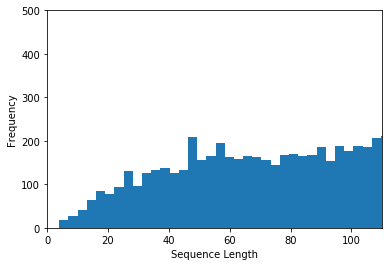

In [36]:
import matplotlib.pyplot as plt
%matplotlib inline
def histograma(numWords):
    plt.hist(numWords, 50)
    plt.xlabel('Sequence Length')
    plt.ylabel('Frequency')
    plt.axis([0, 110, 0, 500])
    plt.show()
histograma(numWords)

Converting each sentence into a vector and adding it into a matrix of 'ids'

In [37]:
def integerSenteces(sent,maximum):
    i = 0
    embbeding = 0
    matrix = np.zeros((len(sent), maximum)) #250 X 45 (numEjem X Maximun)
    for s in sent:
        vector = np.zeros((maximum), dtype='int32')
        s =  s.split()
        bound = maximum
        if len(s) < maximum:
            bound = len(s)    
        for token in range(0,bound): #No encuentra macu, porque la corta
            if s[token] not in wordsList:
                vector[token] = embbeding # ???
                #---print(s[token])
            else:
                vector[token] = (wordsList.index(s[token]))
                embbeding = vector[token]
        matrix[i] = (vector)
        i += 1
    return matrix

In [38]:
X = integerSenteces(train_clean,maxSeqLength) 
print("Sentences integer representation: ",(X.shape))
print("Sentences: ",len(train_clean))
print("Integer format: ",X[249])
print("Normal format: ",train_clean[249])

Sentences integer representation:  (7102, 83)
Sentences:  7102
Integer format:  [8.100e+01 4.300e+01 3.320e+02 5.960e+02 1.318e+03 3.800e+01 4.146e+03
 8.100e+01 1.170e+02 4.100e+01 1.190e+02 5.000e+00 1.200e+01 1.920e+02
 8.350e+02 4.300e+01 3.000e+01 1.920e+02 5.476e+03 0.000e+00 0.000e+00
 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00]
Normal format:  you will never find someone who loved you like i did and that

In [39]:
def toClasses(emo):
    id_emo = []
    for e in emo:
        e = e.split()
        e = e[0]
        if e == 'joy':
            e = 1
        elif e == 'sadness':
            e = 2
        elif e == 'anger':
            e = 3
        elif e == 'fear':
            e = 4
            
        id_emo.append(e)
    return id_emo
emotions = toClasses(emotions)
print(emotions[0]," ",sentences[0])

3   How the fu*k! Who the heck! moved my fridge!... should I knock the landlord door. #angry #mad ##


Split the Data (stratify) into : Train && Test Sets

In [187]:
print("Sentences: ",len(X),"  Labels: ",len(emotions))
X_train, X_test, Y_train, Y_test = train_test_split(X, emotions, test_size=0.20, random_state=random.randrange(50), stratify=emotions)
print("X_train: ",len(X_train),"  Y_train: ",len(Y_train),"  X_test: ",len(X_test),"  Y_test: ",len(Y_test))

Sentences:  7102   Labels:  7102
X_train:  5681   Y_train:  5681   X_test:  1421   Y_test:  1421


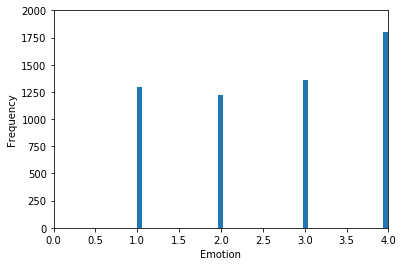

*****************


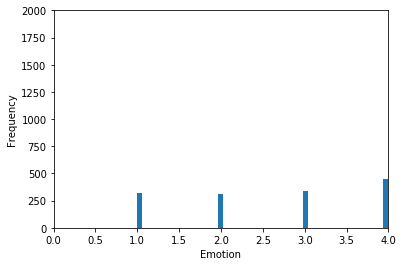

In [188]:
import matplotlib.pyplot as plt
import collections
%matplotlib inline
def histograma(emotion):
    #print(emotion)
    plt.hist(emotion, 50)
    plt.xlabel('Emotion')
    plt.ylabel('Frequency')
    plt.axis([0, 4, 0, 2000])
    plt.show()
histograma(Y_train)
print("*****************")
histograma(Y_test)
#for i in range (0,len(X_train)):
 #   print(Y_train[i],"  ",X_train[i])

Converting the Labels into Onehot Vectors

In [189]:
def toLabels(emo):
    classes = 4
    Y = np.zeros((len(emo), classes)) #Num Ejemplos X 4 emociones
    for e in range(0,len(emo)):
        vector = np.zeros((classes))
        vector[(emo[e] % (classes + 1)) - 1] = 1 
        Y[e] = vector
        #print(emo[e],"---",vector)
    return Y
 
Y_train = toLabels(Y_train)
Y_test = toLabels(Y_test)

In [190]:
print("Y_train: ",Y_train.shape," Num Ejem X # clases")
print("X_train: ",X_train.shape," Num Ejem X Maximun Lengh")
print("Y_test: ",Y_test.shape," Num Ejem X # clases")
print("X_test: ",X_test.shape," Num Ejem X Maximun Lengh")

Y_train:  (5681, 4)  Num Ejem X # clases
X_train:  (5681, 83)  Num Ejem X Maximun Lengh
Y_test:  (1421, 4)  Num Ejem X # clases
X_test:  (1421, 83)  Num Ejem X Maximun Lengh


Test Dataset

RNN Model

In [254]:
def build_rnn(numClasses, maxSeqLength, numDimensions, batchSize, lstmUnits, dropout, learning_rate):
    '''Build the Recurrent Neural Network'''

    tf.reset_default_graph()

    # Declare placeholders we'll feed into the graph
    with tf.name_scope('inputs'):
        inputs = tf.placeholder(tf.int32, [None, maxSeqLength],name='inputs')
        
    
    with tf.name_scope('labels'):
        labels = tf.placeholder(tf.float32, [None, numClasses],name='labels')
    

    keep_prob = tf.placeholder(tf.float32, name='keep_prob')
    
    # Create the embeddings
    with tf.name_scope("embeddings"):
        data = tf.Variable(tf.zeros([batchSize, maxSeqLength, numDimensions]),dtype=tf.float32)
        data = tf.nn.embedding_lookup(wordVectors,inputs)

    # Build the RNN layers
    with tf.name_scope("RNN_layers"):
        lstmCell = tf.contrib.rnn.BasicLSTMCell(lstmUnits)
        lstmCell = tf.contrib.rnn.DropoutWrapper(cell=lstmCell, output_keep_prob=keep_prob)
       
    # Set the initial state
    with tf.name_scope("RNN_init_state"):
        initial_state = lstmCell.zero_state(batchSize, tf.float32)

    # Run the data through the RNN layers
    with tf.name_scope("RNN_forward"):  
        value, final_state = tf.nn.dynamic_rnn(lstmCell, data, initial_state=initial_state)
     
    # Create the fully connected layers
    with tf.name_scope("fully_connected"):
        
        # Initialize the weights and biases
        weight = tf.Variable(tf.truncated_normal([lstmUnits, numClasses]))
        bias = tf.Variable(tf.constant(0.1, shape=[numClasses]))
        value = tf.transpose(value, [1, 0, 2])
        last = tf.gather(value, int(value.get_shape()[0]) - 1)
       
        
    # Make the predictions
    with tf.name_scope('prediction'):
        prediction = (tf.matmul(last, weight) + bias)
        tf.summary.histogram('prediction', prediction)
    
    # Calculate the cost
    with tf.name_scope('cost'):
        cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits_v2(logits=prediction, labels=labels))
        tf.summary.scalar('cost', cost)
        
    
    # Train the model
    with tf.name_scope('train'):    
        optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(cost)

    # Determine the accuracy
    with tf.name_scope("accuracy"):
        
        correctPred = tf.equal(tf.argmax(prediction,1), tf.argmax(labels,1))
        accuracy = tf.reduce_mean(tf.cast(correctPred, tf.float32))       
        tf.summary.scalar('accuracy', accuracy)
        
    
    # Merge all of the summaries
    merged = tf.summary.merge_all()    

    # Export the nodes 
    export_nodes = ['inputs', 'labels','keep_prob', 'initial_state', 'final_state', 'accuracy',
                    'prediction', 'cost', 'optimizer', 'merged']
    Graph = namedtuple('Graph', export_nodes)
    local_dict = locals()
    graph = Graph(*[local_dict[each] for each in export_nodes])
    
    return graph

Trainning && Validation Cycles

In [255]:
def train(model, epochs, log_string):
    '''Train the RNN'''
    saver = tf.train.Saver()
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())

        # Used to determine when to stop the training early
        valid_loss_summary = []
        
        # Metrics Presicion, recall and F1 measure
        val_pre = []
        val_recall = []
        val_f1 = []
        
        # Keep track of which batch iteration is being trained
        iteration = 0

        print()
        print("Training Model: {}".format(log_string))

        train_writer = tf.summary.FileWriter('./logs/3/train/{}'.format(log_string), sess.graph)
        valid_writer = tf.summary.FileWriter('./logs/3/valid/{}'.format(log_string))

        for e in range(epochs):
            state = sess.run(model.initial_state)
            
            # Record progress with each epoch
            train_loss = []
            train_acc = []
            val_acc = []
            val_loss = []
            
            #Create X groups of (50,6) Labels && (50,maximum) Examples
            numEjemplos = 5681   
            total_batch = int(numEjemplos/batchSize)
            X_batches = np.array_split(X_train, total_batch)
            Y_batches = np.array_split(Y_train, total_batch)

            #Train Cycle
            with tqdm(total=len(X_train)) as pbar: #Barra de progreso !!!
                for i in range(total_batch):
                    batch_x, batch_y = X_batches[i], Y_batches[i]
                    feed = {model.inputs: batch_x,
                            model.labels: batch_y,
                            model.keep_prob: dropout,
                            model.initial_state: state}
                    summary, loss, acc, state, _ = sess.run([model.merged, 
                                                             model.cost, 
                                                             model.accuracy, 
                                                             model.final_state, 
                                                             model.optimizer], 
                                                            feed_dict=feed)

                    # Record the loss and accuracy of each training batch
                    train_loss.append(loss)
                    train_acc.append(acc)
                    
                    # Record the progress of training
                    train_writer.add_summary(summary, iteration)
                    
                    iteration += 1
                    pbar.update(batchSize)
            
            # Average the training loss and accuracy of each epoch
            avg_train_loss = np.mean(train_loss)
            avg_train_acc = np.mean(train_acc) 

            #Create X train batchs of batchSize
            numEjemplos = 1421 
            total_batch = int(numEjemplos/batchSize)
            
            X_batches = np.array_split(X_test, total_batch)
            Y_batches = np.array_split(Y_test, total_batch)
            
            if e < epochs - 1:
            # Print the progress of each epoch
                print("Epoch: {}/{}".format(e, epochs),
                        "Train Loss: {:.3f}".format(avg_train_loss),
                        "Train Acc: {:.3f}".format(avg_train_acc))

                
            #Valid Cycle : Solo Valid, en la últimas iteraciones
            else:
                val_state = sess.run(model.initial_state)
                with tqdm(total=len(X_test)) as pbar:
                    for i in range(total_batch):
                        batch_x, batch_y = X_batches[i], Y_batches[i]
                        batch_x = batch_x[:batchSize]
                        batch_y = batch_y[:batchSize]
                        
                        feed = {model.inputs: batch_x,
                                model.labels: batch_y,
                                model.keep_prob: 1,
                                model.initial_state: val_state}
                        summary, batch_loss, batch_acc, val_state, batch_pre = sess.run([model.merged, 
                                                                              model.cost, 
                                                                              model.accuracy, 
                                                                              model.final_state,
                                                                              model.prediction], 
                                                                             feed_dict=feed)


                        #Converting predictions to np.array 
                        y_pred = tf.argmax(batch_pre , 1).eval({model.inputs: batch_x, model.labels: batch_y})
                        y_true = (tf.argmax(batch_y , 1).eval()) 
                        precision = precision_score(y_true, y_pred, average=None)
                        recall = recall_score(y_true, y_pred, average=None)
                        f1 = f1_score(y_true, y_pred, average=None)

                        # Record the validation loss and accuracy of each epoch
                        val_loss.append(batch_loss)
                        val_acc.append(batch_acc)
                        val_pre.append(precision)
                        val_recall.append(recall)
                        val_f1.append(f1)
                        pbar.update(batchSize)



                # Average the validation loss and accuracy of each epoch
                avg_valid_loss = np.mean(val_loss)    
                avg_valid_acc = np.mean(val_acc)
                valid_loss_summary.append(avg_valid_loss)
                avg_pre = np.mean(val_pre)
                avg_recall = np.mean(val_recall)
                avg_f1 = np.mean(val_f1)

                # Record the validation data's progress
                valid_writer.add_summary(summary, iteration)


                print("Epoch: {}/{}".format(e, epochs),
                "Train Loss: {:.3f}".format(avg_train_loss),
                "Train Acc: {:.3f}".format(avg_train_acc),
                "Valid Loss: {:.3f}".format(avg_valid_loss),
                "Valid Acc: {:.3f}".format(avg_valid_acc),
                "Valid Pre: {:.3f}".format(avg_pre),
                "Valid Reca: {:.3f}".format(avg_recall),
                "Valid F1: {:.3f}".format(avg_f1))
                
                class_names = ["Hapinnes","Sadness","Anger","Fear"]
                print(classification_report(y_true, y_pred, target_names=class_names))
                
                
                # Compute confusion matrix
                cnf_matrix = confusion_matrix(y_true, y_pred)
                np.set_printoptions(precision=2)

                # Plot non-normalized confusion matrix
                plt.figure()
                plot_confusion_matrix(cnf_matrix, classes=class_names,
                                      title='Confusion matrix, without normalization')

                # Plot normalized confusion matrix
                plt.figure()
                plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=True,
                                      title='Normalized confusion matrix')

                plt.show()
    
            checkpoint = "C:/Users/danie/Desktop/Checkpoints/sentiment_{}.ckpt".format(log_string)
            saver.save(sess, checkpoint)

Declarando placeholders para los labels (6 emotions) && data imput

In [261]:
# The default parameters of the model
numDimensions = 300 
batchSize = 437 #Tiene que ser multiplo del NumEjem
lstmUnits = 64
numClasses = 4
dropout = 0.5
learning_rate = 0.001
epochs = 150
bachTam = batchSize


Training Model: ru=6,fcl=10,fcu=96


100%|██████████| 5681/5681 [00:05<00:00, 1247.26it/s]


Epoch: 0/150 Train Loss: 1.379 Train Acc: 0.311


100%|██████████| 5681/5681 [00:04<00:00, 1285.73it/s]


Epoch: 1/150 Train Loss: 1.375 Train Acc: 0.317


100%|██████████| 5681/5681 [00:05<00:00, 1194.51it/s]


Epoch: 2/150 Train Loss: 1.367 Train Acc: 0.326


100%|██████████| 5681/5681 [00:04<00:00, 1300.37it/s]


Epoch: 3/150 Train Loss: 1.329 Train Acc: 0.374


100%|██████████| 5681/5681 [00:04<00:00, 1297.95it/s]


Epoch: 4/150 Train Loss: 1.289 Train Acc: 0.404


100%|██████████| 5681/5681 [00:04<00:00, 1271.15it/s]


Epoch: 5/150 Train Loss: 1.260 Train Acc: 0.413


100%|██████████| 5681/5681 [00:04<00:00, 1319.95it/s]


Epoch: 6/150 Train Loss: 1.255 Train Acc: 0.416


100%|██████████| 5681/5681 [00:04<00:00, 1301.54it/s]


Epoch: 7/150 Train Loss: 1.239 Train Acc: 0.425


100%|██████████| 5681/5681 [00:04<00:00, 1298.17it/s]


Epoch: 8/150 Train Loss: 1.224 Train Acc: 0.428


100%|██████████| 5681/5681 [00:04<00:00, 1318.14it/s]


Epoch: 9/150 Train Loss: 1.201 Train Acc: 0.440


100%|██████████| 5681/5681 [00:04<00:00, 1307.81it/s]


Epoch: 10/150 Train Loss: 1.191 Train Acc: 0.442


100%|██████████| 5681/5681 [00:04<00:00, 1292.16it/s]


Epoch: 11/150 Train Loss: 1.180 Train Acc: 0.442


100%|██████████| 5681/5681 [00:04<00:00, 1314.24it/s]


Epoch: 12/150 Train Loss: 1.161 Train Acc: 0.451


100%|██████████| 5681/5681 [00:04<00:00, 1318.56it/s]


Epoch: 13/150 Train Loss: 1.155 Train Acc: 0.456


100%|██████████| 5681/5681 [00:04<00:00, 1265.59it/s]


Epoch: 14/150 Train Loss: 1.147 Train Acc: 0.456


100%|██████████| 5681/5681 [00:04<00:00, 1305.43it/s]


Epoch: 15/150 Train Loss: 1.123 Train Acc: 0.462


100%|██████████| 5681/5681 [00:04<00:00, 1325.93it/s]


Epoch: 16/150 Train Loss: 1.101 Train Acc: 0.467


100%|██████████| 5681/5681 [00:04<00:00, 1291.49it/s]


Epoch: 17/150 Train Loss: 1.086 Train Acc: 0.476


100%|██████████| 5681/5681 [00:04<00:00, 1308.27it/s]


Epoch: 18/150 Train Loss: 1.078 Train Acc: 0.480


100%|██████████| 5681/5681 [00:04<00:00, 1297.55it/s]


Epoch: 19/150 Train Loss: 1.082 Train Acc: 0.480


100%|██████████| 5681/5681 [00:04<00:00, 1323.88it/s]


Epoch: 20/150 Train Loss: 1.072 Train Acc: 0.499


100%|██████████| 5681/5681 [00:04<00:00, 1250.10it/s]


Epoch: 21/150 Train Loss: 1.068 Train Acc: 0.499


100%|██████████| 5681/5681 [00:04<00:00, 1322.58it/s]


Epoch: 22/150 Train Loss: 1.054 Train Acc: 0.503


100%|██████████| 5681/5681 [00:04<00:00, 1333.56it/s]


Epoch: 23/150 Train Loss: 1.029 Train Acc: 0.511


100%|██████████| 5681/5681 [00:04<00:00, 1324.63it/s]


Epoch: 24/150 Train Loss: 1.012 Train Acc: 0.523


100%|██████████| 5681/5681 [00:04<00:00, 1320.47it/s]


Epoch: 25/150 Train Loss: 0.993 Train Acc: 0.526


100%|██████████| 5681/5681 [00:04<00:00, 1304.47it/s]


Epoch: 26/150 Train Loss: 0.972 Train Acc: 0.534


100%|██████████| 5681/5681 [00:04<00:00, 1319.05it/s]


Epoch: 27/150 Train Loss: 0.970 Train Acc: 0.532


100%|██████████| 5681/5681 [00:04<00:00, 1273.53it/s]


Epoch: 28/150 Train Loss: 0.955 Train Acc: 0.545


100%|██████████| 5681/5681 [00:04<00:00, 1296.30it/s]


Epoch: 29/150 Train Loss: 0.941 Train Acc: 0.547


100%|██████████| 5681/5681 [00:04<00:00, 1317.97it/s]


Epoch: 30/150 Train Loss: 0.952 Train Acc: 0.542


100%|██████████| 5681/5681 [00:04<00:00, 1304.68it/s]


Epoch: 31/150 Train Loss: 0.927 Train Acc: 0.547


100%|██████████| 5681/5681 [00:04<00:00, 1309.78it/s]


Epoch: 32/150 Train Loss: 0.906 Train Acc: 0.555


100%|██████████| 5681/5681 [00:04<00:00, 1264.43it/s]


Epoch: 33/150 Train Loss: 0.921 Train Acc: 0.556


100%|██████████| 5681/5681 [00:04<00:00, 1283.04it/s]


Epoch: 34/150 Train Loss: 0.919 Train Acc: 0.557


100%|██████████| 5681/5681 [00:04<00:00, 1306.63it/s]


Epoch: 35/150 Train Loss: 0.917 Train Acc: 0.559


100%|██████████| 5681/5681 [00:04<00:00, 1272.26it/s]


Epoch: 36/150 Train Loss: 0.893 Train Acc: 0.575


100%|██████████| 5681/5681 [00:04<00:00, 1230.32it/s]


Epoch: 37/150 Train Loss: 0.886 Train Acc: 0.578


100%|██████████| 5681/5681 [00:04<00:00, 1307.76it/s]


Epoch: 38/150 Train Loss: 0.876 Train Acc: 0.581


100%|██████████| 5681/5681 [00:04<00:00, 1293.92it/s]


Epoch: 39/150 Train Loss: 0.877 Train Acc: 0.583


100%|██████████| 5681/5681 [00:04<00:00, 1277.98it/s]


Epoch: 40/150 Train Loss: 0.900 Train Acc: 0.568


100%|██████████| 5681/5681 [00:04<00:00, 1289.20it/s]


Epoch: 41/150 Train Loss: 0.867 Train Acc: 0.581


100%|██████████| 5681/5681 [00:04<00:00, 1286.69it/s]


Epoch: 42/150 Train Loss: 0.844 Train Acc: 0.598


100%|██████████| 5681/5681 [00:04<00:00, 1291.94it/s]


Epoch: 43/150 Train Loss: 0.825 Train Acc: 0.598


100%|██████████| 5681/5681 [00:04<00:00, 1222.05it/s]


Epoch: 44/150 Train Loss: 0.795 Train Acc: 0.616


100%|██████████| 5681/5681 [00:04<00:00, 1301.51it/s]


Epoch: 45/150 Train Loss: 0.794 Train Acc: 0.616


100%|██████████| 5681/5681 [00:04<00:00, 1329.44it/s]


Epoch: 46/150 Train Loss: 0.799 Train Acc: 0.612


100%|██████████| 5681/5681 [00:04<00:00, 1326.23it/s]


Epoch: 47/150 Train Loss: 0.812 Train Acc: 0.608


100%|██████████| 5681/5681 [00:04<00:00, 1328.22it/s]


Epoch: 48/150 Train Loss: 0.806 Train Acc: 0.617


100%|██████████| 5681/5681 [00:04<00:00, 1329.18it/s]


Epoch: 49/150 Train Loss: 0.823 Train Acc: 0.613


100%|██████████| 5681/5681 [00:04<00:00, 1324.40it/s]


Epoch: 50/150 Train Loss: 0.797 Train Acc: 0.613


100%|██████████| 5681/5681 [00:04<00:00, 1316.81it/s]


Epoch: 51/150 Train Loss: 0.800 Train Acc: 0.616


100%|██████████| 5681/5681 [00:04<00:00, 1306.41it/s]


Epoch: 52/150 Train Loss: 0.787 Train Acc: 0.620


100%|██████████| 5681/5681 [00:04<00:00, 1276.68it/s]


Epoch: 53/150 Train Loss: 0.762 Train Acc: 0.635


100%|██████████| 5681/5681 [00:04<00:00, 1328.16it/s]


Epoch: 54/150 Train Loss: 0.746 Train Acc: 0.639


100%|██████████| 5681/5681 [00:04<00:00, 1318.96it/s]


Epoch: 55/150 Train Loss: 0.757 Train Acc: 0.634


100%|██████████| 5681/5681 [00:04<00:00, 1257.87it/s]


Epoch: 56/150 Train Loss: 0.795 Train Acc: 0.626


100%|██████████| 5681/5681 [00:04<00:00, 1327.42it/s]


Epoch: 57/150 Train Loss: 0.799 Train Acc: 0.612


100%|██████████| 5681/5681 [00:04<00:00, 1323.88it/s]


Epoch: 58/150 Train Loss: 0.785 Train Acc: 0.628


100%|██████████| 5681/5681 [00:04<00:00, 1322.30it/s]


Epoch: 59/150 Train Loss: 0.759 Train Acc: 0.637


100%|██████████| 5681/5681 [00:04<00:00, 1249.42it/s]


Epoch: 60/150 Train Loss: 0.732 Train Acc: 0.652


100%|██████████| 5681/5681 [00:04<00:00, 1323.47it/s]


Epoch: 61/150 Train Loss: 0.730 Train Acc: 0.654


100%|██████████| 5681/5681 [00:04<00:00, 1335.41it/s]


Epoch: 62/150 Train Loss: 0.734 Train Acc: 0.653


100%|██████████| 5681/5681 [00:04<00:00, 1333.12it/s]


Epoch: 63/150 Train Loss: 0.725 Train Acc: 0.664


100%|██████████| 5681/5681 [00:04<00:00, 1339.44it/s]


Epoch: 64/150 Train Loss: 0.779 Train Acc: 0.627


100%|██████████| 5681/5681 [00:04<00:00, 1336.02it/s]


Epoch: 65/150 Train Loss: 0.861 Train Acc: 0.601


100%|██████████| 5681/5681 [00:04<00:00, 1320.41it/s]


Epoch: 66/150 Train Loss: 0.757 Train Acc: 0.645


100%|██████████| 5681/5681 [00:04<00:00, 1253.13it/s]


Epoch: 67/150 Train Loss: 0.709 Train Acc: 0.667


100%|██████████| 5681/5681 [00:04<00:00, 1327.47it/s]


Epoch: 68/150 Train Loss: 0.747 Train Acc: 0.649


100%|██████████| 5681/5681 [00:04<00:00, 1299.44it/s]


Epoch: 69/150 Train Loss: 0.730 Train Acc: 0.666


100%|██████████| 5681/5681 [00:04<00:00, 1318.38it/s]


Epoch: 70/150 Train Loss: 0.691 Train Acc: 0.696


100%|██████████| 5681/5681 [00:04<00:00, 1320.93it/s]


Epoch: 71/150 Train Loss: 0.652 Train Acc: 0.706


100%|██████████| 5681/5681 [00:04<00:00, 1306.90it/s]


Epoch: 72/150 Train Loss: 0.645 Train Acc: 0.712


100%|██████████| 5681/5681 [00:04<00:00, 1327.89it/s]


Epoch: 73/150 Train Loss: 0.635 Train Acc: 0.710


100%|██████████| 5681/5681 [00:04<00:00, 1259.24it/s]


Epoch: 74/150 Train Loss: 0.629 Train Acc: 0.721


100%|██████████| 5681/5681 [00:04<00:00, 1322.94it/s]


Epoch: 75/150 Train Loss: 0.626 Train Acc: 0.727


100%|██████████| 5681/5681 [00:04<00:00, 1298.08it/s]


Epoch: 76/150 Train Loss: 0.624 Train Acc: 0.725


100%|██████████| 5681/5681 [00:04<00:00, 1310.13it/s]


Epoch: 77/150 Train Loss: 0.642 Train Acc: 0.720


100%|██████████| 5681/5681 [00:04<00:00, 1318.97it/s]


Epoch: 78/150 Train Loss: 0.633 Train Acc: 0.718


100%|██████████| 5681/5681 [00:04<00:00, 1301.93it/s]


Epoch: 79/150 Train Loss: 0.658 Train Acc: 0.713


100%|██████████| 5681/5681 [00:04<00:00, 1326.11it/s]


Epoch: 80/150 Train Loss: 0.672 Train Acc: 0.711


100%|██████████| 5681/5681 [00:04<00:00, 1256.52it/s]


Epoch: 81/150 Train Loss: 0.668 Train Acc: 0.722


100%|██████████| 5681/5681 [00:04<00:00, 1304.24it/s]


Epoch: 82/150 Train Loss: 0.604 Train Acc: 0.748


100%|██████████| 5681/5681 [00:04<00:00, 1294.18it/s]


Epoch: 83/150 Train Loss: 0.569 Train Acc: 0.768


100%|██████████| 5681/5681 [00:04<00:00, 1299.48it/s]


Epoch: 84/150 Train Loss: 0.553 Train Acc: 0.774


100%|██████████| 5681/5681 [00:04<00:00, 1304.48it/s]


Epoch: 85/150 Train Loss: 0.539 Train Acc: 0.788


100%|██████████| 5681/5681 [00:04<00:00, 1264.33it/s]


Epoch: 86/150 Train Loss: 0.522 Train Acc: 0.796


100%|██████████| 5681/5681 [00:04<00:00, 1255.19it/s]


Epoch: 87/150 Train Loss: 0.519 Train Acc: 0.800


100%|██████████| 5681/5681 [00:04<00:00, 1219.64it/s]


Epoch: 88/150 Train Loss: 0.503 Train Acc: 0.808


100%|██████████| 5681/5681 [00:04<00:00, 1296.06it/s]


Epoch: 89/150 Train Loss: 0.510 Train Acc: 0.805


100%|██████████| 5681/5681 [00:04<00:00, 1293.60it/s]


Epoch: 90/150 Train Loss: 0.527 Train Acc: 0.797


100%|██████████| 5681/5681 [00:04<00:00, 1286.79it/s]


Epoch: 91/150 Train Loss: 0.508 Train Acc: 0.809


100%|██████████| 5681/5681 [00:04<00:00, 1307.41it/s]


Epoch: 92/150 Train Loss: 0.504 Train Acc: 0.808


100%|██████████| 5681/5681 [00:04<00:00, 1307.17it/s]


Epoch: 93/150 Train Loss: 0.488 Train Acc: 0.820


100%|██████████| 5681/5681 [00:04<00:00, 1327.50it/s]


Epoch: 94/150 Train Loss: 0.491 Train Acc: 0.813


100%|██████████| 5681/5681 [00:04<00:00, 1299.65it/s]


Epoch: 95/150 Train Loss: 0.477 Train Acc: 0.825


100%|██████████| 5681/5681 [00:04<00:00, 1320.52it/s]


Epoch: 96/150 Train Loss: 0.485 Train Acc: 0.812


100%|██████████| 5681/5681 [00:04<00:00, 1333.53it/s]


Epoch: 97/150 Train Loss: 0.479 Train Acc: 0.822


100%|██████████| 5681/5681 [00:04<00:00, 1341.29it/s]


Epoch: 98/150 Train Loss: 0.464 Train Acc: 0.832


100%|██████████| 5681/5681 [00:04<00:00, 1328.56it/s]


Epoch: 99/150 Train Loss: 0.468 Train Acc: 0.829


100%|██████████| 5681/5681 [00:04<00:00, 1297.82it/s]


Epoch: 100/150 Train Loss: 0.485 Train Acc: 0.824


100%|██████████| 5681/5681 [00:04<00:00, 1332.29it/s]


Epoch: 101/150 Train Loss: 0.443 Train Acc: 0.839


100%|██████████| 5681/5681 [00:04<00:00, 1267.03it/s]


Epoch: 102/150 Train Loss: 0.431 Train Acc: 0.848


100%|██████████| 5681/5681 [00:04<00:00, 1331.69it/s]


Epoch: 103/150 Train Loss: 0.413 Train Acc: 0.854


100%|██████████| 5681/5681 [00:04<00:00, 1287.07it/s]


Epoch: 104/150 Train Loss: 0.425 Train Acc: 0.852


100%|██████████| 5681/5681 [00:04<00:00, 1332.28it/s]


Epoch: 105/150 Train Loss: 0.411 Train Acc: 0.853


100%|██████████| 5681/5681 [00:04<00:00, 1327.16it/s]


Epoch: 106/150 Train Loss: 0.427 Train Acc: 0.850


100%|██████████| 5681/5681 [00:04<00:00, 1308.84it/s]


Epoch: 107/150 Train Loss: 0.423 Train Acc: 0.852


100%|██████████| 5681/5681 [00:04<00:00, 1327.32it/s]


Epoch: 108/150 Train Loss: 0.450 Train Acc: 0.833


100%|██████████| 5681/5681 [00:04<00:00, 1295.13it/s]


Epoch: 109/150 Train Loss: 0.456 Train Acc: 0.836


100%|██████████| 5681/5681 [00:04<00:00, 1323.05it/s]


Epoch: 110/150 Train Loss: 0.442 Train Acc: 0.842


100%|██████████| 5681/5681 [00:04<00:00, 1320.97it/s]


Epoch: 111/150 Train Loss: 0.466 Train Acc: 0.831


100%|██████████| 5681/5681 [00:04<00:00, 1336.13it/s]


Epoch: 112/150 Train Loss: 0.513 Train Acc: 0.805


100%|██████████| 5681/5681 [00:04<00:00, 1328.14it/s]


Epoch: 113/150 Train Loss: 0.534 Train Acc: 0.795


100%|██████████| 5681/5681 [00:04<00:00, 1305.79it/s]


Epoch: 114/150 Train Loss: 0.520 Train Acc: 0.811


100%|██████████| 5681/5681 [00:04<00:00, 1316.68it/s]


Epoch: 115/150 Train Loss: 0.414 Train Acc: 0.855


100%|██████████| 5681/5681 [00:04<00:00, 1282.79it/s]


Epoch: 116/150 Train Loss: 0.425 Train Acc: 0.847


100%|██████████| 5681/5681 [00:04<00:00, 1323.46it/s]


Epoch: 117/150 Train Loss: 0.397 Train Acc: 0.862


100%|██████████| 5681/5681 [00:04<00:00, 1341.57it/s]


Epoch: 118/150 Train Loss: 0.355 Train Acc: 0.877


100%|██████████| 5681/5681 [00:04<00:00, 1340.37it/s]


Epoch: 119/150 Train Loss: 0.353 Train Acc: 0.882


100%|██████████| 5681/5681 [00:04<00:00, 1327.88it/s]


Epoch: 120/150 Train Loss: 0.349 Train Acc: 0.889


100%|██████████| 5681/5681 [00:04<00:00, 1192.62it/s]


Epoch: 121/150 Train Loss: 0.336 Train Acc: 0.884


100%|██████████| 5681/5681 [00:04<00:00, 1323.57it/s]


Epoch: 122/150 Train Loss: 0.332 Train Acc: 0.886


100%|██████████| 5681/5681 [00:04<00:00, 1252.09it/s]


Epoch: 123/150 Train Loss: 0.357 Train Acc: 0.883


100%|██████████| 5681/5681 [00:04<00:00, 1310.46it/s]


Epoch: 124/150 Train Loss: 0.342 Train Acc: 0.888


100%|██████████| 5681/5681 [00:04<00:00, 1312.54it/s]


Epoch: 125/150 Train Loss: 0.337 Train Acc: 0.888


100%|██████████| 5681/5681 [00:04<00:00, 1342.95it/s]


Epoch: 126/150 Train Loss: 0.336 Train Acc: 0.884


100%|██████████| 5681/5681 [00:04<00:00, 1313.09it/s]


Epoch: 127/150 Train Loss: 0.340 Train Acc: 0.888


100%|██████████| 5681/5681 [00:04<00:00, 1297.54it/s]


Epoch: 128/150 Train Loss: 0.374 Train Acc: 0.872


100%|██████████| 5681/5681 [00:04<00:00, 1318.03it/s]


Epoch: 129/150 Train Loss: 0.347 Train Acc: 0.884


100%|██████████| 5681/5681 [00:04<00:00, 1240.74it/s]


Epoch: 130/150 Train Loss: 0.331 Train Acc: 0.892


100%|██████████| 5681/5681 [00:04<00:00, 1299.41it/s]


Epoch: 131/150 Train Loss: 0.296 Train Acc: 0.902


100%|██████████| 5681/5681 [00:04<00:00, 1297.08it/s]


Epoch: 132/150 Train Loss: 0.281 Train Acc: 0.912


100%|██████████| 5681/5681 [00:04<00:00, 1302.07it/s]


Epoch: 133/150 Train Loss: 0.266 Train Acc: 0.918


100%|██████████| 5681/5681 [00:04<00:00, 1295.62it/s]


Epoch: 134/150 Train Loss: 0.255 Train Acc: 0.922


100%|██████████| 5681/5681 [00:04<00:00, 1280.52it/s]


Epoch: 135/150 Train Loss: 0.254 Train Acc: 0.922


100%|██████████| 5681/5681 [00:04<00:00, 1290.16it/s]


Epoch: 136/150 Train Loss: 0.292 Train Acc: 0.902


100%|██████████| 5681/5681 [00:04<00:00, 1248.83it/s]


Epoch: 137/150 Train Loss: 0.324 Train Acc: 0.894


100%|██████████| 5681/5681 [00:04<00:00, 1310.06it/s]


Epoch: 138/150 Train Loss: 0.258 Train Acc: 0.916


100%|██████████| 5681/5681 [00:04<00:00, 1271.58it/s]


Epoch: 139/150 Train Loss: 0.283 Train Acc: 0.907


100%|██████████| 5681/5681 [00:04<00:00, 1325.32it/s]


Epoch: 140/150 Train Loss: 0.259 Train Acc: 0.919


100%|██████████| 5681/5681 [00:04<00:00, 1327.40it/s]


Epoch: 141/150 Train Loss: 0.296 Train Acc: 0.897


100%|██████████| 5681/5681 [00:04<00:00, 1331.74it/s]


Epoch: 142/150 Train Loss: 0.287 Train Acc: 0.904


100%|██████████| 5681/5681 [00:04<00:00, 1341.65it/s]


Epoch: 143/150 Train Loss: 0.311 Train Acc: 0.893


100%|██████████| 5681/5681 [00:04<00:00, 1273.85it/s]


Epoch: 144/150 Train Loss: 0.292 Train Acc: 0.904


100%|██████████| 5681/5681 [00:04<00:00, 1331.95it/s]


Epoch: 145/150 Train Loss: 0.338 Train Acc: 0.879


100%|██████████| 5681/5681 [00:04<00:00, 1331.67it/s]


Epoch: 146/150 Train Loss: 0.385 Train Acc: 0.858


100%|██████████| 5681/5681 [00:04<00:00, 1330.31it/s]


Epoch: 147/150 Train Loss: 0.428 Train Acc: 0.853


100%|██████████| 5681/5681 [00:04<00:00, 1343.90it/s]


Epoch: 148/150 Train Loss: 0.414 Train Acc: 0.861


 92%|█████████▏| 1311/1421 [00:02<00:00, 535.83it/s]


Epoch: 149/150 Train Loss: 0.319 Train Acc: 0.893 Valid Loss: 1.239 Valid Acc: 0.678 Valid Pre: 0.698 Valid Reca: 0.671 Valid F1: 0.679
             precision    recall  f1-score   support

   Hapinnes       0.78      0.75      0.76        95
    Sadness       0.65      0.58      0.61        97
      Anger       0.77      0.62      0.68       104
       Fear       0.58      0.72      0.64       141

avg / total       0.68      0.67      0.67       437

Confusion matrix, without normalization
[[ 71   7   3  14]
 [  6  56   1  34]
 [  6   7  64  27]
 [  8  16  15 102]]
Normalized confusion matrix
[[0.75 0.07 0.03 0.15]
 [0.06 0.58 0.01 0.35]
 [0.06 0.07 0.62 0.26]
 [0.06 0.11 0.11 0.72]]


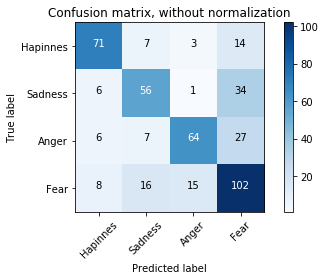

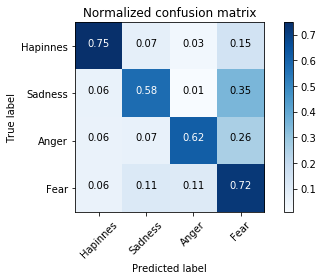

In [262]:
log_string = 'ru={},fcl={},fcu={}'.format(6,10,96)
model = build_rnn(numClasses = numClasses,
                              maxSeqLength=maxSeqLength,
                              numDimensions=numDimensions,
                              batchSize = batchSize,
                              lstmUnits = lstmUnits,
                              dropout = dropout,
                              learning_rate = learning_rate)       
train(model, epochs, log_string)

In [ ]:
Hacer ultimo chekpoint . en base a F1


Probar con Stop words y otras mod.
Limpiar #poorattention
@@ estas haciendo valid con batch pqueño , no con todo el gigante, pero no importan en el test se hace asi
pondras 

Tensorboar

In [207]:
import datetime
def board(sess):
    tf.summary.scalar('Loss', loss)
    tf.summary.scalar('Accuracy', accuracy)
    tf.summary.histogram("Histogrma/hAccu", accuracy)
    merged = tf.summary.merge_all()
    logdir = "board/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S") + "/"
    writer = tf.summary.FileWriter(logdir, sess.graph)
    return merged,writer

Confusion Matrix Plot

In [208]:
import itertools
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

In [84]:
from collections import Counter
from sklearn.datasets import make_classification
from imblearn.over_sampling import SMOTE  
print('Balance',Counter(emotions))

Balance Counter({4: 1257, 3: 941, 1: 902, 2: 860})


In [ ]:
from imblearn.over_sampling import SMOTE, ADASYN
#Banlancea ADASYN
X_balance, Y_balance = ADASYN().fit_sample(X,emotions)
print('Balance',Counter(Y_balance))

In [48]:
print(X_balance.shape," ",Y_balance.shape)
print(len(X)," ",len(emotion))

(7836, 15)   (7836,)
3695   3695


In [49]:
X_train_b, X_test_b, Y_train_b, Y_test_b = train_test_split(X_balance, Y_balance, test_size=0.13, random_state=random.randrange(50), stratify=Y_balance)
print("X_train: ",len(X_train_b),"  Y_train: ",len(Y_train_b),"  X_test: ",len(X_test_b),"  Y_test: ",len(Y_test_b))

X_train:  6817   Y_train:  6817   X_test:  1019   Y_test:  1019


In [50]:
Y_train_b = toLabels(Y_train_b)
Y_test_b = toLabels(Y_test_b)

Otro Modelo: Solo balanceamos Trainset

In [ ]:
#Averogua ottros modelos
#Cambie el keep_drop
#Cambia learning rate
#Cambie num unidades 128?
#Prueba con tu modelo

In [110]:
def train(model, epochs, log_string):
    '''Train the RNN'''

    saver = tf.train.Saver()
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())

        # Used to determine when to stop the training early
        valid_loss_summary = []
        
        # Metrics Presicion, recall and F1 measure
        val_pre = []
        val_recall = []
        val_f1 = []
        
        # Keep track of which batch iteration is being trained
        iteration = 0

        print()
        print("Training Model: {}".format(log_string))

        train_writer = tf.summary.FileWriter('./logs/3/train/{}'.format(log_string), sess.graph)
        valid_writer = tf.summary.FileWriter('./logs/3/valid/{}'.format(log_string))

        for e in range(epochs):
            state = sess.run(model.initial_state)
            
            # Record progress with each epoch
            train_loss = []
            train_acc = []
            val_acc = []
            val_loss = []
            
            #Create X groups of (50,6) Labels && (50,maximum) Examples
            numEjemplos = 3168  
            total_batch = int(numEjemplos/batchSize)
            X_batches = np.array_split(X_train, total_batch)
            Y_batches = np.array_split(Y_train, total_batch)

            #Train Cycle
            with tqdm(total=len(X_train)) as pbar: #Barra de progreso !!!
                for i in range(total_batch):
                    batch_x, batch_y = X_batches[i], Y_batches[i]
                    feed = {model.inputs: batch_x,
                            model.labels: batch_y,
                            model.keep_prob: dropout,
                            model.initial_state: state}
                    summary, loss, acc, state, _ = sess.run([model.merged, 
                                                             model.cost, 
                                                             model.accuracy, 
                                                             model.final_state, 
                                                             model.optimizer], 
                                                            feed_dict=feed)

                    # Record the loss and accuracy of each training batch
                    train_loss.append(loss)
                    train_acc.append(acc)
                    
                    # Record the progress of training
                    train_writer.add_summary(summary, iteration)
                    
                    iteration += 1
                    pbar.update(batchSize)
            
            # Average the training loss and accuracy of each epoch
            avg_train_loss = np.mean(train_loss)
            avg_train_acc = np.mean(train_acc) 

            #Create X train batchs of batchSize
            numEjemplos = 792  
            total_batch =  math.floor(numEjemplos/batchSize)
            
            X_batches = np.array_split(X_test, total_batch)
            Y_batches = np.array_split(Y_test, total_batch)
                
            #Valid Cycle
            val_state = sess.run(model.initial_state)
            with tqdm(total=len(X_test)) as pbar:
                for i in range(total_batch):
                    batch_x, batch_y = X_batches[i], Y_batches[i]
                    feed = {model.inputs: batch_x,
                            model.labels: batch_y,
                            model.keep_prob: 1,
                            model.initial_state: val_state}
                    summary, batch_loss, batch_acc, val_state, batch_pre = sess.run([model.merged, 
                                                                          model.cost, 
                                                                          model.accuracy, 
                                                                          model.final_state,
                                                                          model.prediction], 
                                                                         feed_dict=feed)
                    
                    
                    #Converting predictions to np.array 
                    y_pred = tf.argmax(batch_pre , 1).eval({model.inputs: batch_x, model.labels: batch_y})
                    y_true = (tf.argmax(batch_y , 1).eval()) 
                    precision = precision_score(y_true, y_pred, average=None)
                    recall = recall_score(y_true, y_pred, average=None)
                    f1 = f1_score(y_true, y_pred, average=None)
                    
                    # Record the validation loss and accuracy of each epoch
                    val_loss.append(batch_loss)
                    val_acc.append(batch_acc)
                    val_pre.append(precision)
                    val_recall.append(recall)
                    val_f1.append(f1)
                    pbar.update(batchSize)
                    
                    
            
            # Average the validation loss and accuracy of each epoch
            avg_valid_loss = np.mean(val_loss)    
            avg_valid_acc = np.mean(val_acc)
            valid_loss_summary.append(avg_valid_loss)
            avg_pre = np.mean(val_pre)
            avg_recall = np.mean(val_recall)
            avg_f1 = np.mean(val_f1)
            
            # Record the validation data's progress
            valid_writer.add_summary(summary, iteration)

            # Print the progress of each epoch
            print("Epoch: {}/{}".format(e, epochs),
                  "Train Loss: {:.3f}".format(avg_train_loss),
                  "Train Acc: {:.3f}".format(avg_train_acc),
                  "Valid Loss: {:.3f}".format(avg_valid_loss),
                  "Valid Acc: {:.3f}".format(avg_valid_acc))

            if e > 148:
                print("Epoch: {}/{}".format(e, epochs),
                "Train Loss: {:.3f}".format(avg_train_loss),
                "Train Acc: {:.3f}".format(avg_train_acc),
                "Valid Loss: {:.3f}".format(avg_valid_loss),
                "Valid Acc: {:.3f}".format(avg_valid_acc),
                "Valid Pre: {:.3f}".format(avg_pre),
                "Valid Reca: {:.3f}".format(avg_recall),
                "Valid F1: {:.3f}".format(avg_f1))
                
                class_names = ["Hapinnes","Sadness","Anger","Fear"]
                print(classification_report(y_true, y_pred, target_names=class_names))
                
            # Stop training if the validation loss does not decrease after 3 epochs
            if avg_valid_loss > min(valid_loss_summary):
                print("No Improvement.")
                #-----stop_early += 1
                if stop_early == 3:
                    break   
            
            # Reset stop_early if the validation loss finds a new low
            # Save a checkpoint of the model
            else:
                print("New Record!")
                stop_early = 0
                checkpoint = "C:/Users/UX310UQ/Desktop/CheckPoints/sentiment_{}.ckpt".format(log_string)
                saver.save(sess, checkpoint)